In [1]:
'''
#Gigacow-tools# - preprocessing
This scripts used for Gigacow data cleaning work.
Data Tables: gigacow.csv, lactation.csv, traffic.csv, robot.csv
'''

import pandas as pd
import numpy as np

'''
func:Calculate cows age based on BirthDate and CullDate
Input:Two expected situations: alive/culled
return:cow age in human years(float)
'''
def countCowAge(x, y):
    #alive cows
    if pd.notna(x) and pd.isna(y):
        x = pd.to_datetime(x)
        days = np.float32(np.datetime64('today') - np.datetime64(x, 'D'))
    #culled cows
    else:
        x = pd.to_datetime(x)
        y = pd.to_datetime(y)
        days = np.float32(np.datetime64(y, 'D') - np.datetime64(x, 'D'))
    age = np.around(days/365, 2)
    return age

#access data from local directory
dataDir = "C:/Users/Savior_Hn/Desktop/Gigacow/"

#filter out irrelevant columns
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate', 'CullDecisionDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
traffic_cols = ['Traffic_Id', 'FarmName_Pseudo', 'Gigacow_Cow_Id', 'TrafficEventDateTime', 'PreviousArea', 'TimeInArea_totalSeconds', 'TrafficDeviceName', 'TrafficResult', 'MilkingInterval_totalSeconds']
robot_cols = ['MilkRobot_Id', 'FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingStartDateTime', 'SessionNumber', 'EquipmentName', 'TotalYield', 'MilkingUnitName']
gigacow = pd.read_csv(dataDir+'gigacow.csv', usecols=gigacow_cols, encoding='utf-8')
lactation = pd.read_csv(dataDir+'lactation.csv', usecols=lactation_cols, encoding='utf-8')
traffic = pd.read_csv(dataDir+'traffic.csv', usecols=traffic_cols, encoding='utf-8')
robot = pd.read_csv(dataDir+'robot.csv', usecols=robot_cols, encoding='utf-8')

#data table: gigacow 
#target farms: f454e660, a624fb9a
farm_list = ['f454e660', 'a624fb9a']
gigacow = gigacow.loc[gigacow['FarmName_Pseudo'].isin(farm_list)]
#drop cows without birthdate
gigacow = gigacow.dropna(subset=['BirthDate'])
#calculate age of cows
gigacow['Age'] = gigacow.apply(lambda x: countCowAge(x['BirthDate'], x['CullDecisionDate']), axis=1)
gigacow.drop(['BirthDate', 'CullDecisionDate'], axis=1, inplace=True)

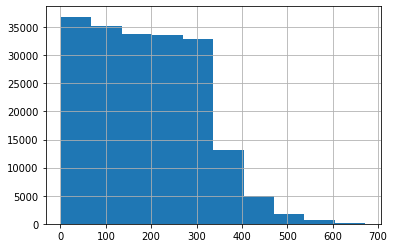

In [6]:
#data table: lactation 
#target farms: f454e660, a624fb9a
lactation = lactation.loc[lactation['FarmName_Pseudo'].isin(farm_list)]
#drop anomalies in DaysinMilk
#lactation = lactation.loc[lactation['DaysInMilk'] <= 330]

#Lactation Period
#plot the histogram of cows days in milk
lactation.DaysInMilk.hist()
lactation.DaysInMilk.describe()
#merge table lactation and robot
robot_lactation = robot.merge(lactation, how='left', on='Gigacow_Cow_Id')

In [7]:
robot_lactation

,MilkRobot_Id,FarmName_Pseudo_x,Gigacow_Cow_Id,MilkingStartDateTime,SessionNumber,EquipmentName,TotalYield,FarmName_Pseudo_y,LactationInfoDate,LactationNumber,DaysInMilk
0,1,a624fb9a,3300,2019-11-27 00:04:00,1.0,vms1,8.53,a624fb9a,2022-05-02,4.0,382.0
1,1,a624fb9a,3300,2019-11-27 00:04:00,1.0,vms1,8.53,a624fb9a,2021-06-05,4.0,52.0
2,1,a624fb9a,3300,2019-11-27 00:04:00,1.0,vms1,8.53,a624fb9a,2020-07-03,3.0,224.0
3,1,a624fb9a,3300,2019-11-27 00:04:00,1.0,vms1,8.53,a624fb9a,2021-07-04,4.0,81.0
4,1,a624fb9a,3300,2019-11-27 00:04:00,1.0,vms1,8.53,a624fb9a,2020-06-06,3.0,197.0
...,...,...,...,...,...,...,...,...,...,...,...
307245536,1062865,a624fb9a,5465,2022-06-26 01:54:00,1.0,vms1,10.94,a624fb9a,2022-06-16,2.0,12.0
307245537,1062865,a624fb9a,5465,2022-06-26 01:54:00,1.0,vms1,10.94,a624fb9a,2021-12-27,1.0,212.0
307245538,1062865,a624fb9a,5465,2022-06-26 01:54:00,1.0,vms1,10.94,a624fb9a,2022-07-26,2.0,52.0
307245539,1062865,a624fb9a,5465,2022-06-26 01:54:00,1.0,vms1,10.94,a624fb9a,2022-08-09,2.0,66.0


In [6]:
#data table: traffic
#target farms: f454e660, a624fb9a
traffic = traffic.loc[traffic['FarmName_Pseudo'].isin(farm_list)]
#Unifiy traffic device name(vms1 & vms2)
traffic['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
#extract traffic result(milk production)
traffic['TrafficResult'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
traffic['TrafficResult'].replace(r"\s*","", inplace=True, regex=True)
traffic['TrafficResult'].replace(r"[,]+",".", inplace=True, regex=True)
traffic.drop_duplicates(subset=['Gigacow_Cow_Id', 'TrafficEventDateTime'], inplace=True)

In [7]:
traffic.to_csv('traffic_filter.csv')
print(traffic['TrafficResult'])

0         19.13
1         20.00
2         12.10
3          6.56
4         12.91
          ...  
828007    20.11
828008     5.91
828009    10.03
828011     7.03
828018    11.52
Name: TrafficResult, Length: 303242, dtype: object


In [ ]:
#data table: robot
#target farms: f454e660, a624fb9a
robot = robot.loc[robot['FarmName_Pseudo'].isin(farm_list)]
#Unifiy robot equipment name(vms1 & vms2)
robot['EquipmentName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
robot['MilkingUnitName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)

'''
    Q:check if equipmentName and milkingUnitName are exact same
    result:rows equipmentName and milkingUnitName are exact same
'''
#robot['EquipmentName'].equals(['MilkingUnitName'])
#robot['New'] = robot.apply(lambda x: x['EquipmentName'] if x['EquipmentName'] == x['MilkingUnitName'] else np.nan, axis=1)
#robot.to_csv('robot_filter.csv')
robot.drop('MilkingUnitName', axis=1, inplace=True)

#drop NA value in data table robot
robot.dropna(subset=['TotalYield'], axis=0, inplace=True)


In [13]:
robot.to_csv('robot_filter.csv')

In [ ]:
'''
    check if TrafficResult and total TotalYield are same
    result: part same, robot results include traffic results
'''
#apply full outer join on two data tables
#robot_traffic = robot.merge(traffic, how='outer', on='Gigacow_Cow_Id')

In [ ]:
robot_traffic

In [3]:
robot

,MilkRobot_Id,FarmName_Pseudo,Gigacow_Cow_Id,MilkingStartDateTime,SessionNumber,EquipmentName,TotalYield
0,1,a624fb9a,3300,2019-11-27 00:04:00,1.0,vms1,8.53
1,2,a624fb9a,3674,2019-11-27 00:36:00,1.0,vms2,11.16
2,3,a624fb9a,992,2019-11-27 01:14:00,1.0,vms1,8.33
3,4,a624fb9a,3194,2019-11-27 01:49:00,1.0,vms2,13.47
4,5,a624fb9a,5348,2019-11-27 02:05:00,1.0,vms2,14.26
...,...,...,...,...,...,...,...
1046162,1062852,a624fb9a,1585,2021-12-02 12:24:00,1.0,vms2,9.86
1046168,1062858,f454e660,5246,2021-05-09 08:05:00,1.0,vms1,16.20
1046169,1062859,f454e660,2354,2021-07-24 17:18:00,2.0,vms2,12.75
1046170,1062860,f454e660,1244,2022-06-05 04:07:00,1.0,vms1,11.20


In [ ]:
#join the tables

In [8]:
gigacow

,Gigacow_Cow_Id,FarmName_Pseudo,BreedName,Age
2,2,f454e660,01 SRB,3.68
7,7,a624fb9a,01 SRB,1.86
10,10,f454e660,01 SRB,7.39
16,16,f454e660,99 Korsning/obestämbar ras,0.68
17,17,f454e660,01 SRB,3.89
...,...,...,...,...
6472,6472,f454e660,04 SJB,3.70
6484,6484,a624fb9a,02 SLB,1.82
6485,6485,f454e660,02 SLB,3.98
6487,6487,f454e660,02 SLB,4.60


In [4]:
lactation

,FarmName_Pseudo,Gigacow_Cow_Id,LactationInfoDate,LactationNumber,DaysInMilk
1,a624fb9a,5160,2021-09-08,1,67.0
2,f454e660,4311,2022-04-11,1,118.0
4,f454e660,5545,2022-08-11,5,218.0
5,a624fb9a,3173,2020-02-28,2,273.0
9,a624fb9a,3207,2021-09-26,1,254.0
...,...,...,...,...,...
638258,a624fb9a,4833,2020-08-27,5,64.0
638261,f454e660,2770,2021-04-18,3,204.0
638266,a624fb9a,560,2020-12-27,1,352.0
638267,a624fb9a,151,2022-08-09,1,199.0


In [10]:
traffic

,Traffic_Id,FarmName_Pseudo,Gigacow_Cow_Id,TrafficEventDateTime,PreviousArea,TimeInArea_totalSeconds,TrafficDeviceName,TrafficResult,MilkingInterval_totalSeconds
0,10,f454e660,730,2022-04-01 10:19:56,Mjölkfålla,120,Vms 1,"Mjölkning 19,13 kg",37020
1,18,f454e660,849,2021-12-19 02:56:41,Mjölkfålla,0,Vms 1,"Mjölkning 20,00 kg",35460
2,19,f454e660,2844,2022-02-04 17:45:51,Mjölkfålla,4260,Vms 1,"Mjölkning 12,10 kg",31860
3,22,f454e660,2460,2022-07-21 11:44:29,Foderbord,8220,Vms 1,"Mjölkning 6,56 kg",38760
4,50,f454e660,2724,2022-06-24 11:13:36,Mjölkfålla,2520,Vms 1,"Mjölkning 12,91 kg",38040
...,...,...,...,...,...,...,...,...,...
828015,10721171,f454e660,5278,2022-07-15 21:34:32,Mjölkfålla,1800,vms 2,"Mjölkning 6,07 kg",16560
828016,10721188,a624fb9a,2712,2020-08-19 07:07:06,Mjolkfalla,300,VMS2,Milking 12.32 kg,36720
828017,10721190,f454e660,1420,2022-02-12 20:54:11,Mjölkfålla,840,vms 2,"Mjölkning 6,69 kg",29820
828018,10721224,a624fb9a,32,2021-11-18 05:14:52,Mjolkfalla,60,MS1,Milking 11.52 kg,21780


In [11]:
robot

,MilkRobot_Id,FarmName_Pseudo,Gigacow_Cow_Id,MilkingStartDateTime,SessionNumber,EquipmentName,TotalYield,MilkingUnitName
0,1,a624fb9a,3300,2019-11-27 00:04:00,1.0,VMS 1,8.53,VMS 1
1,2,a624fb9a,3674,2019-11-27 00:36:00,1.0,VMS2,11.16,VMS2
2,3,a624fb9a,992,2019-11-27 01:14:00,1.0,VMS 1,8.33,VMS 1
3,4,a624fb9a,3194,2019-11-27 01:49:00,1.0,VMS2,13.47,VMS2
4,5,a624fb9a,5348,2019-11-27 02:05:00,1.0,VMS2,14.26,VMS2
...,...,...,...,...,...,...,...,...
1046172,1062862,ab18b151,6239,2021-03-30 02:12:00,NaN,MS1,NaN,MS1
1046173,1062863,ab18b151,1161,2021-11-19 22:55:00,4.0,MS2,9.70,MS2
1046174,1062864,ab18b151,5306,2021-12-27 06:34:00,1.0,MS1,16.70,MS1
1046175,1062865,a624fb9a,5465,2022-06-26 01:54:00,1.0,MS1,10.94,MS1
